A template of the RL training

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime

from utils import print_log

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load the created dataset
dataset_folder_path = Path("dataset", "20250707", "split")

In [4]:
# copied from 03_data_split.ipynb

# Helper functions for the new split folder structure
def load_split_data_from_folder(split_folder, split_type='train'):
    """Load aggregate data from split folder"""
    segments = []
    with open(split_folder / f'{split_type}_segments.txt', 'r') as f:
        for line in f:
            start_str, end_str = line.strip().split(' - ')
            start = datetime.fromisoformat(start_str)
            end = datetime.fromisoformat(end_str)
            segments.append((start, end))
    
    df = pd.read_pickle(split_folder / f'{split_type}_aggregate_df.pkl')
    return segments, df

def load_signatures_from_split_folder(split_folder, split_type, appliance):
    """Load appliance signatures from split folder"""
    sig_path = split_folder / 'load_signature_library' / split_type / appliance / 'load_signatures.pkl'
    ranges_path = split_folder / 'load_signature_library' / split_type / appliance / 'selected_ranges.txt'
    
    if not sig_path.exists():
        return pd.DataFrame(), []
    
    signatures_df = pd.read_pickle(sig_path)
    ranges = []
    if ranges_path.exists():
        with open(ranges_path, 'r') as f:
            for line in f:
                start, end = map(int, line.strip().split(','))
                ranges.append((start, end))
    
    return signatures_df, ranges

In [5]:
aggregate_load_segments_train, aggregate_load_df_train = load_split_data_from_folder(dataset_folder_path, 'train')
aggregate_load_segments_test, aggregate_load_df_test = load_split_data_from_folder(dataset_folder_path, 'test') 
aggregate_load_segments_validation, aggregate_load_df_validation = load_split_data_from_folder(dataset_folder_path, 'val')

In [6]:
aggregate_load_df_train

,timestamp,aggregate,datetime,washing_machine,dishwasher,fridge,kettle,microwave,toaster,tv,htpc,gas_oven,kitchen_lights
0,1.357603e+09,234.0,2013-01-08 00:00:05+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,69.0,NaN,0.0
1,1.357603e+09,231.0,2013-01-08 00:00:11+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,70.0,NaN,0.0
2,1.357603e+09,234.0,2013-01-08 00:00:17+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,70.0,NaN,0.0
3,1.357603e+09,232.0,2013-01-08 00:00:23+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,68.0,NaN,0.0
4,1.357603e+09,232.0,2013-01-08 00:00:30+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,70.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231636,1.388448e+09,178.0,2013-12-30 23:59:35+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
2231637,1.388448e+09,177.0,2013-12-30 23:59:41+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
2231638,1.388448e+09,178.0,2013-12-30 23:59:47+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
2231639,1.388448e+09,178.0,2013-12-30 23:59:53+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0


In [7]:
aggregate_load_segments_train

[(datetime.datetime(2013, 1, 8, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 10, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 2, 27, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 2, 28, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 3, 8, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 3, 10, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 3, 28, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 3, 31, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 3, 22, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 3, 26, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 4, 8, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 4, 10, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 4, 26, 0, 0, tzinfo=datetime.timezone.utc),
  d

In [8]:
from rl_env.env_data_loader import SmartMeterDataLoader

sm_dl = SmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_train,
    aggregate_load_df=aggregate_load_df_train
)

sm_dl.get_divided_segments_length()

162

In [9]:
sm_dl.divided_segments[7]

array([datetime.datetime(2013, 3, 10, 0, 0, tzinfo=datetime.timezone.utc),
       datetime.datetime(2013, 3, 10, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)],
      dtype=object)

In [10]:
load_segment = sm_dl.get_aggregate_load_segment(13)

load_segment

,timestamp,aggregate,datetime
104747,1.363997e+09,335.0,2013-03-23 00:00:05+00:00
104748,1.363997e+09,336.0,2013-03-23 00:00:11+00:00
104749,1.363997e+09,333.0,2013-03-23 00:00:17+00:00
104750,1.363997e+09,334.0,2013-03-23 00:00:24+00:00
104751,1.363997e+09,331.0,2013-03-23 00:00:30+00:00
...,...,...,...
118501,1.364083e+09,179.0,2013-03-23 23:59:30+00:00
118502,1.364083e+09,171.0,2013-03-23 23:59:37+00:00
118503,1.364083e+09,171.0,2013-03-23 23:59:43+00:00
118504,1.364083e+09,171.0,2013-03-23 23:59:49+00:00


In [11]:
load_segment['datetime'] = pd.to_datetime(load_segment['timestamp'], unit='s')

load_segment

,timestamp,aggregate,datetime
104747,1.363997e+09,335.0,2013-03-23 00:00:05
104748,1.363997e+09,336.0,2013-03-23 00:00:11
104749,1.363997e+09,333.0,2013-03-23 00:00:17
104750,1.363997e+09,334.0,2013-03-23 00:00:24
104751,1.363997e+09,331.0,2013-03-23 00:00:30
...,...,...,...
118501,1.364083e+09,179.0,2013-03-23 23:59:30
118502,1.364083e+09,171.0,2013-03-23 23:59:37
118503,1.364083e+09,171.0,2013-03-23 23:59:43
118504,1.364083e+09,171.0,2013-03-23 23:59:49


(Optional) Load the pre-trained H-network and related components

In final product, the H-network should be trained along with the DDQL/PPO agent

In [12]:
import torch
from model.H_network.h_network import HNetwork

h_network_path = Path("model_trained", "h_network_20250708.pth")

h_network = HNetwork(2, 44, 1)
h_network.load_state_dict(torch.load(h_network_path))
h_network.eval()

HNetwork(
  (LSTM_1): LSTM(2, 44, batch_first=True, bidirectional=True)
  (ac1): Tanh()
  (LSTM_2): LSTM(88, 1, batch_first=True, bidirectional=True)
  (ac2): Tanh()
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [13]:
h_network_stdscaler_path = Path("model_trained", "h_network_standardscaler_20250708.pkl")
import joblib
h_network_stdscaler = joblib.load(h_network_stdscaler_path)

Create the environment

In [28]:
import sys
sys.path.append(str(Path('rl_env')))

from rl_env.hrl_env import SmartMeterWorld

env = SmartMeterWorld(
    aggregate_load_df=load_segment,
    render_mode="human",
)

env.set_h_network(h_network)
env.set_h_network_stdscaler(h_network_stdscaler)

Environment passes all checks!


/root/UoM/dissertation/AdversarialSMControl/rl_env/hrl_env.py:339: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  
/root/miniforge3/envs/smartmeter/lib/python3.9/site-packages/gymnasium/utils/env_checker.py:434: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantiating the environment through `gymnasium.make`
  logger.warn(


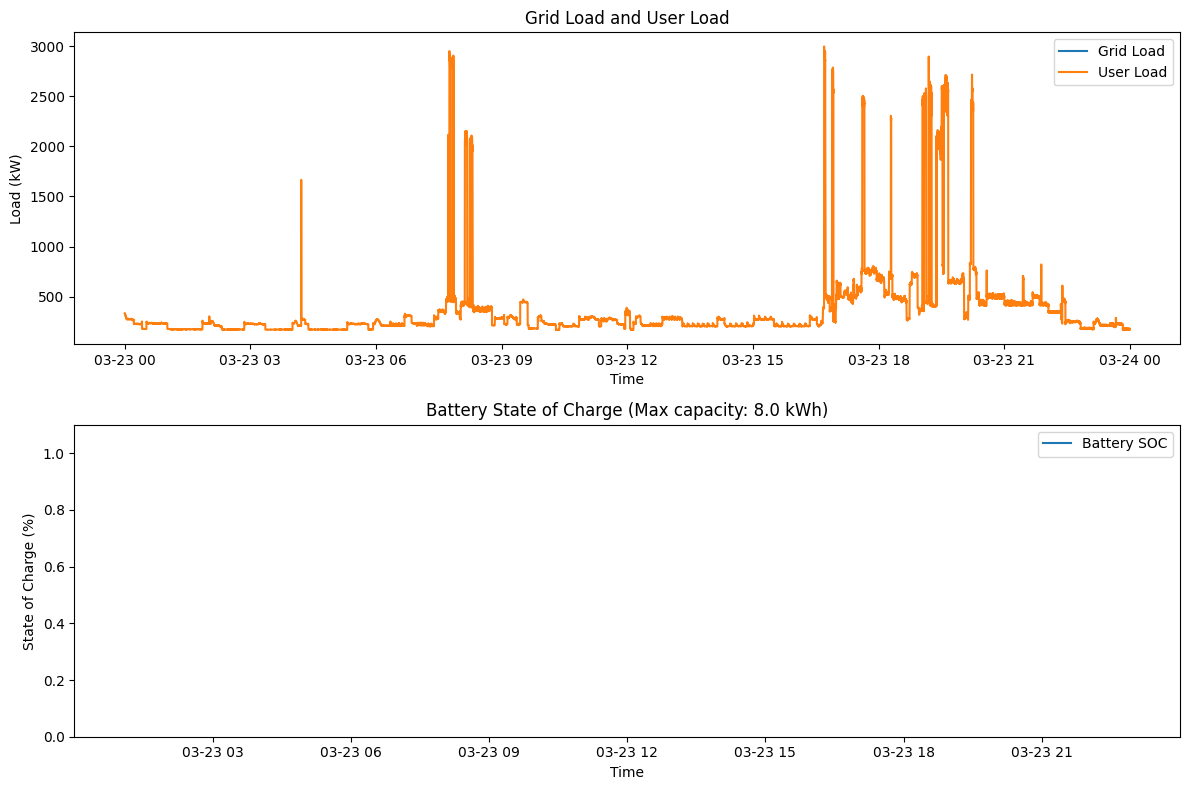

In [29]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

In [30]:
obs = env.reset()
obs

({'aggregate_load': array([335.], dtype=float32),
  'battery_soc': array([0.05382102], dtype=float32),
  'timestamp_features': array([-0.5       ,  0.33333334, -0.25      ], dtype=float32)},
 {})

In [31]:
# initialize a PPO agent
from stable_baselines3 import PPO

rl_datetime = datetime.now()
tensorboard_log_path = Path("rl_model", "PPO", f"{rl_datetime.strftime('%Y%m%d_%H%M%S')}")

rl_model = PPO(
    "MultiInputPolicy", 
    env, 
    verbose=2,
    tensorboard_log=tensorboard_log_path
)

rl_model.learn(
    total_timesteps=1000,
    progress_bar=True,
    tb_log_name="PPO_SmartMeterWorld"
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to rl_model/PPO/20250708_183515/PPO_SmartMeterWorld_1


Output()

-----------------------------
| time/              |      |
|    fps             | 117  |
|    iterations      | 1    |
|    time_elapsed    | 17   |
|    total_timesteps | 2048 |
-----------------------------


[2025-07-08 18:35:53:610] Step: 1, Action: [0.06734122], Reward: 1.069454334104707
[2025-07-08 18:35:53:617] Step: 2, Action: [0.06734122], Reward: 0.3310208836442729
[2025-07-08 18:35:53:627] Step: 3, Action: [0.06734122], Reward: 0.1425608104256375
[2025-07-08 18:35:53:635] Step: 4, Action: [0.06734122], Reward: 0.07674481662576398
[2025-07-08 18:35:53:640] Step: 5, Action: [0.06734122], Reward: 0.0520034873730441
[2025-07-08 18:35:53:646] Step: 6, Action: [0.06734122], Reward: 0.04248497577970227
[2025-07-08 18:35:53:652] Step: 7, Action: [0.06734122], Reward: 0.037313129178807136
[2025-07-08 18:35:53:659] Step: 8, Action: [0.06734122], Reward: 0.03402250202707946
[2025-07-08 18:35:53:668] Step: 9, Action: [0.06734122], Reward: 0.03177447187118232
[2025-07-08 18:35:53:679] Step: 10, Action: [0.06734122], Reward: 0.02980166172068566
[2025-07-08 18:35:53:686] Step: 11, Action: [0.06734122], Reward: 0.028603881023451686
[2025-07-08 18:35:53:693] Step: 12, Action: [0.06734122], Reward: 

/root/UoM/dissertation/AdversarialSMControl/rl_env/hrl_env.py:339: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  


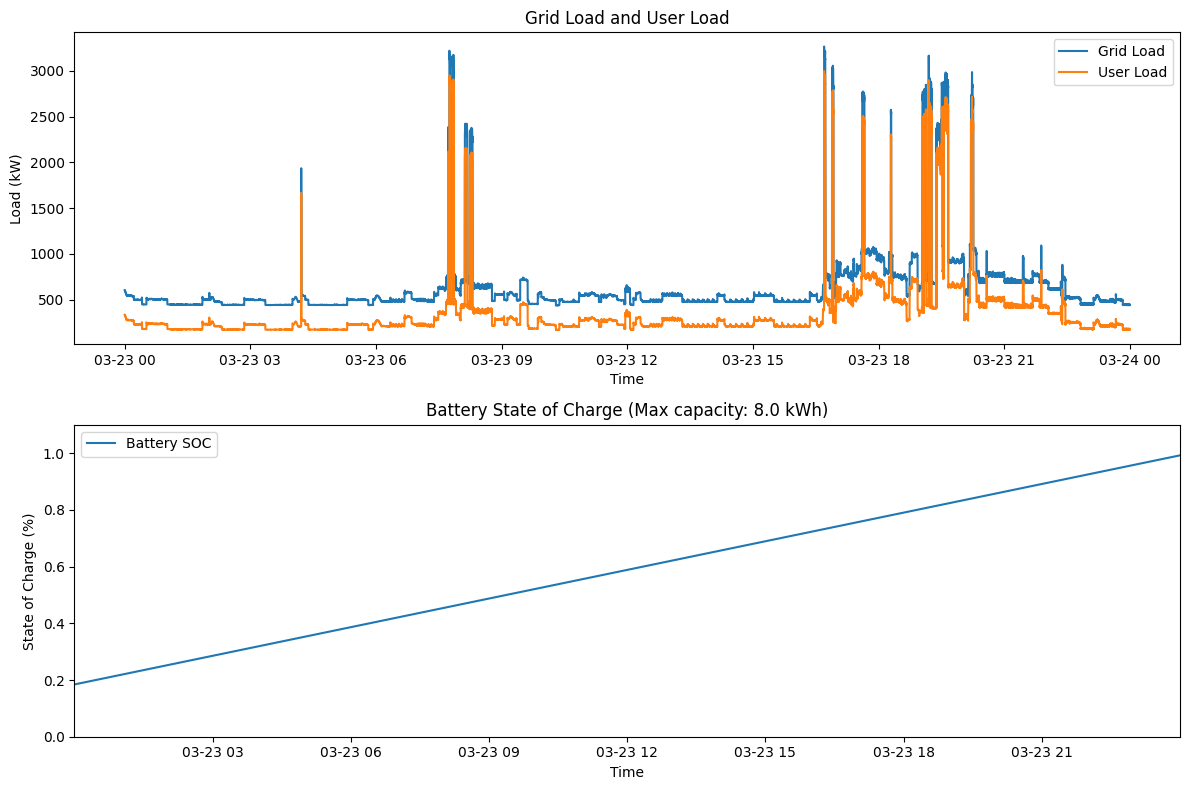

In [32]:
obs, info = env.reset()
for i in range(1):
    done = False
    while not done:
        action, _states = rl_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        print_log(f"Step: {env.current_step}, Action: {action}, Reward: {reward}")
        # env.render()

        if done:
            env.render()


In [33]:
env.aggregate_load_df

,timestamp,aggregate,datetime,grid_load,battery_soc
104747,1.363997e+09,335.0,2013-03-23 00:00:05,604.364893,0.184372
104748,1.363997e+09,336.0,2013-03-23 00:00:11,605.364893,0.184428
104749,1.363997e+09,333.0,2013-03-23 00:00:17,602.364893,0.184484
104750,1.363997e+09,334.0,2013-03-23 00:00:24,603.364893,0.18455
104751,1.363997e+09,331.0,2013-03-23 00:00:30,600.364893,0.184606
...,...,...,...,...,...
118501,1.364083e+09,179.0,2013-03-23 23:59:30,448.34582,0.992127
118502,1.364083e+09,171.0,2013-03-23 23:59:37,440.338816,0.992192
118503,1.364083e+09,171.0,2013-03-23 23:59:43,440.338816,0.992248
118504,1.364083e+09,171.0,2013-03-23 23:59:49,440.338816,0.992304
